In [1]:
!nvidia-smi

Fri Nov 14 08:17:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!unzip -q "/content/Helmet Detection.v1i.yolov11.zip" -d "/content/Helmet Detection.v1i.yolov11"


In [ ]:
!unzip -q "/content/dataset_5.zip"

root_dir = '/content/dataset_5'

In [3]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.9 MB/s eta 0:00:00


In [6]:
!yolo train model = yolov8n.pt data=/content/Helmet_Detection/Helmet_Detection/data.yaml epochs=30 imgsz=640


Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Helmet_Detection/Helmet_Detection/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective

In [7]:
!pip install supervision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 15.8 MB/s eta 0:00:00


In [8]:
import supervision as sv
from ultralytics import YOLO

In [9]:

# Load YOLOv8 model
model = YOLO("/content/runs/detect/train/weights/best.pt")


In [29]:

#Perform inference on an image
results = model("/content/img.jpg")


image 1/1 /content/img.jpg: 480x640 4 With Helmets, 41.7ms
Speed: 6.4ms preprocess, 41.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


In [30]:

#convert detections to supervision format
detections = sv.Detections.from_ultralytics(results[0])

In [31]:

#Define multiple classes to count
selected_classes = ['With Helmet', 'Without Helmet']


In [32]:
#Get the correct class IDs from the dictionary
selected_class_ids = [class_id for class_id, name in model.names.items() if name in selected_classes]


In [33]:
#Ensure class IDs are found
print(f"Selected Class IDs: {selected_class_ids}")

Selected Class IDs: [0, 1]


In [34]:
#Apply filtering
import numpy as np
detections = detections[np.isin(detections.class_id, selected_class_ids)]


In [35]:
#Print the number of detections
print(f"Total objects detected for {selected_classes} : {len(detections)}")

Total objects detected for ['With Helmet', 'Without Helmet'] : 4


In [36]:
print(model.names) #Display all class names


{0: 'With Helmet', 1: 'Without Helmet'}


In [37]:
import cv2
import numpy as np
import supervision as sv
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

In [38]:
# Load YOLOv8 model
model = YOLO("/content/runs/detect/train/weights/best.pt")

In [39]:

# Run detection on an image
image_path = "/content/img.jpg"
image = cv2.imread(image_path)


0: 480x640 4 With Helmets, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)
Model class names: {0: 'With Helmet', 1: 'Without Helmet'}
Selected class IDs: [0, 1]
Class counts: {'With Helmet': np.int64(4), 'Without Helmet': np.int64(0)}


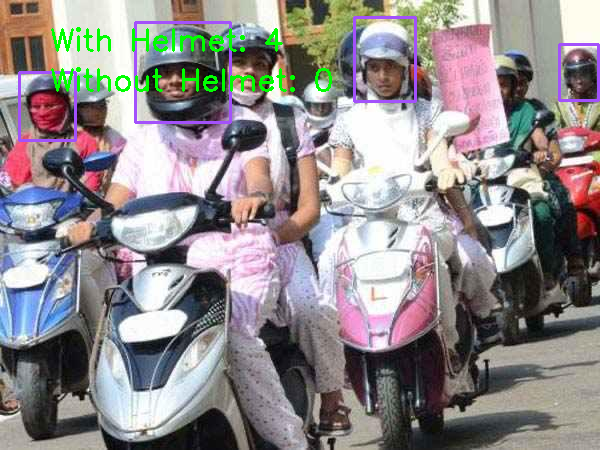

In [40]:
if image is None:
    print(f"Error: Could not load image from {image_path}")
else:
    # Run YOLO model with a confidence threshold
    results = model.predict(image, conf=0.3)

    # Convert YOLO detections to Supervision's Detections object
    detections = sv.Detections.from_ultralytics(results[0])

    # Get class names from the YOLO model
    class_names = model.names
    print(f"Model class names: {class_names}")

    # Ensure class names match exactly with model.names
    selected_classes = ['With Helmet', 'Without Helmet']  # Corrected names

    # Get class IDs for the selected classes
    selected_class_ids = [class_id for class_id, name in class_names.items() if name in selected_classes]
    print(f"Selected class IDs: {selected_class_ids}")

    if not selected_class_ids:
        print("Warning: No matching class IDs found. Please check selected class names.")

    # Filter detections by selected class IDs
    mask = np.isin(detections.class_id, selected_class_ids)
    filtered_detections = detections[mask]

    # Count the detections per class
    class_counts = {class_names[class_id]: np.sum(filtered_detections.class_id == class_id) for class_id in selected_class_ids}
    print(f"Class counts: {class_counts}")

    # Annotate image with bounding boxes
    box_annotator = sv.BoxAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=filtered_detections)

    # Display class counts on the image
    y_offset = 50
    for class_name, count in class_counts.items():
        text = f"{class_name}: {count}"
        cv2.putText(annotated_image, text, (50, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        y_offset += 40

    # Show the final annotated image
    cv2_imshow(annotated_image)

In [41]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 144.8 MB/s eta 0:00:00


34.87.181.165
